<a href="https://colab.research.google.com/github/sgcbayli024/Assignments/blob/main/Conor_Bayliss_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%shell
set -e

JULIA_VERSION="1.9.3"
JULIA_PACKAGES="IJulia BenchmarkTools PyPlot Random Distributions"
JULIA_NUM_THREADS=2


if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Now go to Edit -> Notebook settings, set the kernel to Julia 1.9.3 and confirm."
  echo "Try code cells below.  If they do not work"
  echo "please refresh / reload this page in your browser and try again."
fi

Installing Julia 1.9.3 on the current Colab Runtime...
2023-09-15 14:37:46 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz [146268149/146268149] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package PyPlot...
Installing Julia package Random...
Installing Julia package Distributions...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.9

Now go to Edit -> Notebook settings, set the kernel to Julia 1.9.3 and confirm.
Try code cells below.  If they do not work
please refresh / reload this page in your browser and try again.


In [1]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("Optim")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed OffsetArrays ───── v1.12.10
   Installed Adapt ──────────── v3.6.2
   Installed AxisAlgorithms ─── v1.0.1
   Installed StaticArraysCore ─ v1.4.2
   Installed Ratios ─────────── v0.4.5
   Installed StaticArrays ───── v1.6.3
   Installed WoodburyMatrices ─ v0.5.5
   Installed ChainRulesCore ─── v1.16.0
   Installed Requires ───────── v1.3.0
   Installed Interpolations ─── v0.14.7
    Updating `~/.julia/environments/v1.9/Project.toml`
  [a98d9a8b] + Interpolations v0.14.7
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [79e6a3ab] + Adapt v3.6.2
  [13072b0f] + AxisAlgorithms v1.0.1
  [d360d2e6] + ChainRulesCore v1.16.0
  [a98d9a8b] + Interpolations v0.14.7
  [6fe1bfb0] + OffsetArrays v1.12.10
  [c84ed2f1] + Ratios v0.4.5
  [ae029012] + Requires v1.3.0
  [90137ffa] + StaticArrays v1.6.3
  [1e83bf80] + StaticArraysCore v1.4.2
  [efce3f68] + WoodburyMatrices v0.5.5
  [8ba89e20] 

In [2]:
using Pkg
Pkg.add("PyPlot")
Pkg.add("LaTeXStrings")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [b964fa9f] + LaTeXStrings v1.3.0
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [3]:
using Interpolations, Optim

In [4]:
"""
A function that provides linear interpolation with constant extrapolation
outside the bounds.

    x : a linear grid of interpolation points
    fx : the values of the function on the grid points

"""
function lin_interp(x, fx)
    return linear_interpolation(x, fx,
    extrapolation_bc = Interpolations.Flat())

end

lin_interp

In [5]:
"""
Create an instance of the model, stored as a namedtuple.

"""
function create_opt_savings_model(; β=0.9, #Discount factor
                                    γ=2.0, #CRRA utility parameter
                                    R=1.2, #Gross rate of return
                                    w_size=200, #Grid size for wealth
                                    w_max=10) #maximum wealth
    w_grid = LinRange(1e-8, w_max, w_size) #Create the wealth grid
    u(c)=c^(1-γ)/(1-γ)
    v_init = u.(w_grid) #creating a vector of values for each point in the wealth grid
    return (; β, u, R, w_grid, v_init)
end


create_opt_savings_model

In [6]:
"""
The Bellman operator

    (Tv)(w) = min_{0 ≤ c ≤ w} { u(c) + β v(R(w - c))} Should be max and not min?

"""
function T(v, model)
    (; β, u, R, w_grid) = model

    v_new = similar(v) #create a new vector v_new of exactly the same type as v
    v = lin_interp(w_grid, v)

    for (i, w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w-c)), 0.0, w) #choose the value of c which maximises the statement for each point in the wealth grid
        v_new[i]=Optim.maximum(result)
    end

    return v_new
end


T

In [8]:
" Get a v-greedy policy "
function get_greedy(v, model)
    (; β, u, R, w_grid) = model
    σ = similar(v) #again, create a new vector the same as v. This will be our policy function
    v = lin_interp(w_grid, v)

    for (i,w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w-c)), 0.0, w)
        σ[i]=Optim.maximizer(result) #Notice the difference to the above. The policy function selects which value of c was the maximiser.

    end

    return σ
end

get_greedy

In [9]:
" Value Function Iteration"
function vfi(model;
                tolerance=1e-6,
                max_iter=10_000,
                print_step=100)

    k = 0
    error = tolerance + 1 #initial error, we just need this so we can start the loop
    v=model.v_init

    while (error > tolerance) & (k <= max_iter)
        v_new = T(v, model)
        error = maximum(abs.(v_new - v)) #supnorm. Error is the maximum pairwise distance
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        v = v_new
        k += 1
    end

    if error <= tolerance
        println("Terminated successfully in $k iterations")
    else
        println("Warning: hit iteration bound.")
    end

    σ= get_greedy(v, model) #Given wealth w today, what value of consumption do I choose?
    return σ, v

end

vfi

In [10]:
"""
The policy operator

    (T_σ v)(w) =  u(σ(w)) + β v[R(w - σ(w))]

"""
function T_σ(v, σ, model)
    (; β, u, R, w_grid) = model
    # Add your code here
    v_new= similar(v)
    v=lin_interp(w_grid,v)

    for (i, w) in enumerate(w_grid)
        result = maximize(c->u(c)+β*v(R*(w-c)), 0.0, w)
        σ[i]=Optim.maximum(result) #maximum or maximiser?
    end

    return σ


end

T_σ

In [11]:
"Approximate lifetime value of policy σ."
function get_value(v_init, σ, m, model)
    v = v_init
    k=0
    while k<m
        v = T_σ(v, σ, model)
        k+=1
    end
    return v
    # Compute and return T_σ^m v_init

end

get_value

In [12]:
"Optimistic policy iteration routine."
function opi(model;
              tolerance=1e-6,
              max_iter=1_000,
              m=2000, #20
              print_step=10)
    v = model.v_init
    # Put your code here
    k = 0
    error = tolerance + 1

    while (error > tolerance) & (k<= max_iter)
        σ_new=get_greedy(v, model)
        v_new=get_value(v, σ_new, m, model)
        #v_new = T_σ(v, σ, model)
        error=maximum(abs.(v_new - v))
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        v=v_new
        k+=1
    end

    if error <= tolerance
        println("Terminated successfully in $k iterations.")
    else
        println("Warning: hit iteration bound.")
    end

    σ= get_greedy(v, model)
    return σ, v
end

opi

In [13]:
using PyPlot
using LaTeXStrings
fontsize=12

12

In [14]:
model = create_opt_savings_model()
(; β, u, R, w_grid, v_init) = model;
println("Solving via VFI. \n\n")
@timev σ_star, v_star = vfi(model);

Solving via VFI. 


Completed iteration 0 with error 9.000000634421515e7.
Completed iteration 100 with error 2390.5260684490204.
Completed iteration 200 with error 0.06349575519561768.
Completed iteration 300 with error 1.6689300537109375e-6.
Terminated successfully in 306 iterations
  1.287208 seconds (1.72 M allocations: 116.747 MiB, 5.99% gc time, 92.07% compilation time)
elapsed time (ns):  1287207773
gc time (ns):       77070965
bytes allocated:    122418525
pool allocs:        1714442
non-pool GC allocs: 1291
malloc() calls:     15
free() calls:       54
minor collections:  3
full collections:   0


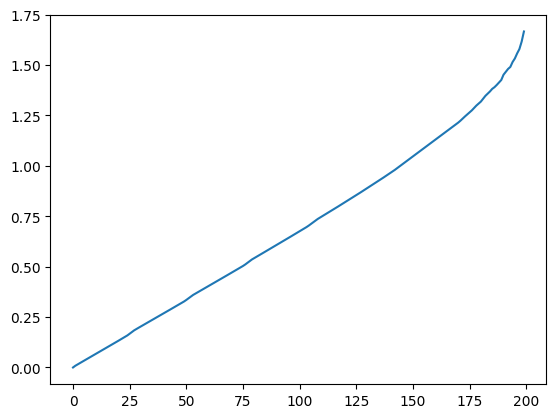

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcaf713c0>

In [27]:
plot(σ_star)

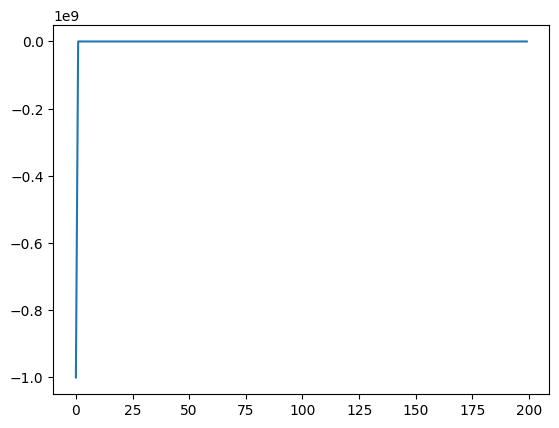

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcb1dd8a0>

In [24]:
plot(v_star)

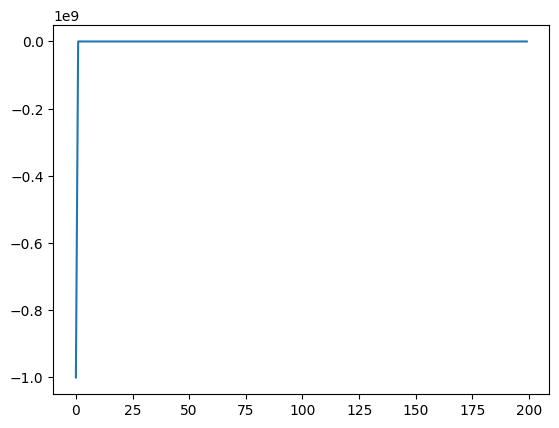

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcb061630>

In [25]:
plot(v_star_hpi)

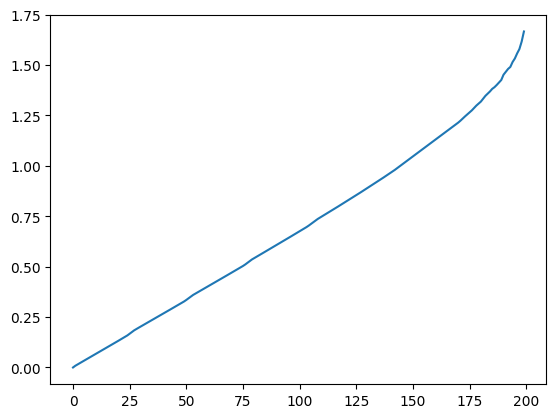

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcb0ec7c0>

In [26]:
plot(σ_star_opi)

In [ ]:
#model = create_opt_savings_model() #This code was just to make sure everything was running ok since I had a couple of issues to iron out in the code.
#(; β, u, R, w_grid, v_init) = model; #Therefore, feel free to ignore this.
#σ=get_greedy(v_init, model)
#v=get_value(v_init, σ, 20, model)

200-element Vector{Float64}:
    -8.905810665975548e8
 -1051.2566445255231
  -520.6074761577372
  -344.07368479585824
  -256.3488263154071
  -204.15797454939823
  -169.60664909493346
  -145.0483871903849
  -126.69561448776179
  -112.46191731076158
     ⋮
    -5.3039446414704265
    -5.280657722036804
    -5.25777229758961
    -5.235710990623158
    -5.2140763479544905
    -5.192858086430046
    -5.1725929463725695
    -5.152787887396123
    -5.1341350381266375

In [16]:
println("\n\nSolving via HPI.\n\n")
@timev σ_star_opi, v_star_hpi = opi(model); #Run time for m=20 is 0.05s. Run time for m=2000 is 0.72s. Run time for m=20000 is 6.45s. Just change the value of m in OPI above.



Solving via HPI.


Completed iteration 0 with error 9.000000634421512e8.
Terminated successfully in 2 iterations.
  1.864637 seconds (1.68 M allocations: 141.073 MiB, 3.56% gc time, 12.74% compilation time)
elapsed time (ns):  1864637466
gc time (ns):       66434992
bytes allocated:    147925808
pool allocs:        1683958
non-pool GC allocs: 108
free() calls:       9
minor collections:  3
full collections:   0


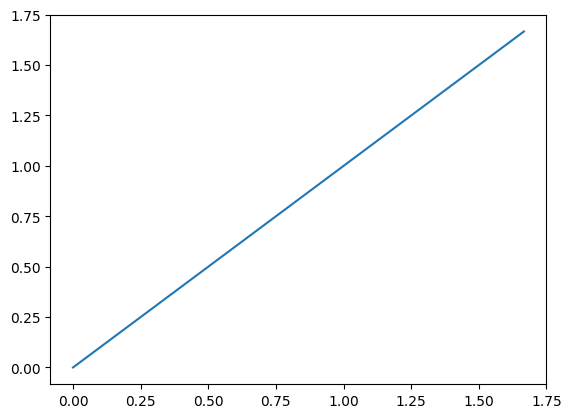

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcb5b4c70>

In [18]:
plot(σ_star_opi, σ_star)

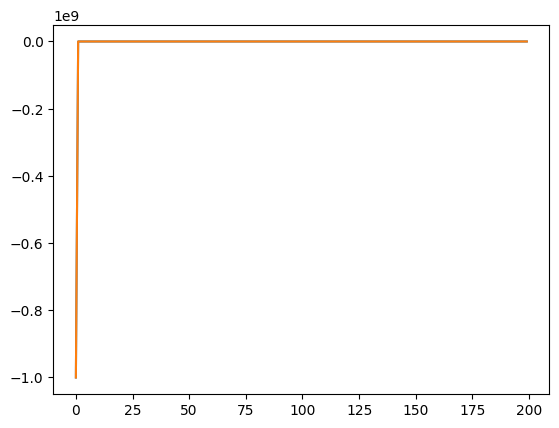

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcb246950>
 PyObject <matplotlib.lines.Line2D object at 0x7f7dcb2469b0>

In [21]:
plot([v_star_hpi v_star])